## Movie Recommender Development

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from surprise import SVD, Dataset, NormalPredictor, Reader
from surprise.model_selection import KFold
from surprise.model_selection.split import train_test_split
import numpy as np

In [2]:
# to install surprise use conda install -c conda-forge scikit-surprise

In [12]:
ratingspath = os.path.join("..","..","data","ml-latest","ratings.csv")
ratings = pd.read_csv(ratingspath)
ratingsorg = ratings

moviespath = os.path.join("..","..","data","ml-latest","movies.csv")
movies = pd.read_csv(moviespath)
moviesorg = movies

In [13]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [14]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [15]:
# extracting date
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True) 

In [16]:
movies.year = pd.to_datetime(movies.year, format = "%Y")
# removing any NAs that may result in decimals
movies.year = movies.year.dt.year
# removing year at end of title
movies.title = movies.title.str[:-7] 

In [17]:
# all different types of genre
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique,columns=['genre'])

# creating boolean columns for each genre
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres',inplace=True, axis=1)

In [9]:
# converting timestamp to date type
ratings.timestamp = pd.to_datetime(ratings.timestamp,infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

In [18]:
movies.dropna(inplace=True)
ratings.dropna(inplace=True)

In [19]:
movies.head()

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji,1995.0,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


Text(0.5, 1.0, 'Movies per Year')

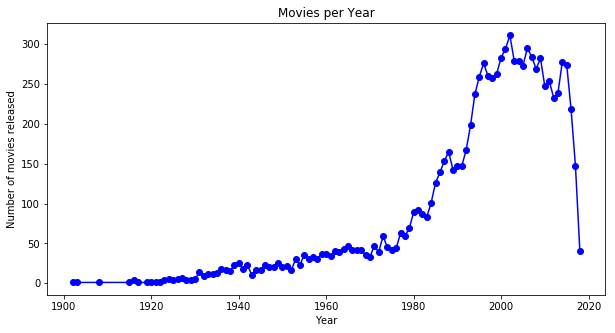

In [14]:
# temp df
tdf = movies[['movieId','year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(tdf.year.first(),tdf.movieId.nunique(),"b-o")


# tdf = ratings[['rating','timestamp']].groupby('timestamp')
# ax2 = ax1.twinx()
# ax2.plot(tdf.timestamp.first(),tdf.rating.count(),'r-o')
ax1.set_ylabel('Number of movies released')
ax1.set_xlabel('Year')
plt.title('Movies per Year')

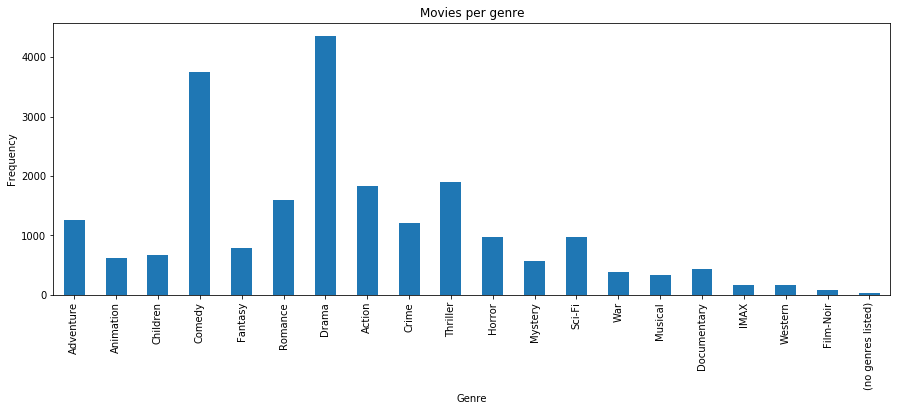

In [16]:
plt.figure(figsize = (15,5))
tdf = movies[['movieId','year']].groupby('year')
df = pd.DataFrame()

# get counts of each genre
for genre in genres_unique.genre:
    tdf = movies[movies[genre]][['movieId','year']].groupby('year')
    df[genre] = tdf.movieId.nunique().cumsum()

df.fillna(method='ffill',inplace=True)

barlist = df.iloc[-1].plot.bar()
plt.title('Movies per genre')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.show()

C:\Users\Sabarish\.conda\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


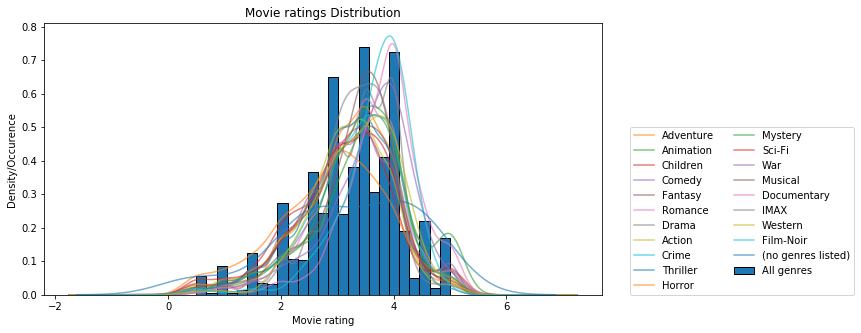

In [17]:
tdf = ratings[['movieId','rating']].groupby('movieId').mean()

rating_stats = []

# plot histogram of all ratings
tdf.hist(bins=25,label='All genres',grid=False,edgecolor='black',normed=True,figsize=(10,5))

for genre in genres_unique.genre:
    tdf = movies[movies[genre]==True]
    tdf = ratings[ratings.set_index('movieId').index.isin(tdf.set_index('movieId').index)]
    tdf = tdf[['movieId','rating']].groupby('movieId').mean()
    tdf.rating.plot(grid=False,alpha=0.6,kind='kde',label=genre)
    avg = tdf.rating.mean()
    std = tdf.rating.std()
    rating_stats.append((genre,avg,std))
plt.legend(loc=(1.05,0),ncol=2)
plt.xlabel('Movie rating')
plt.ylabel('Density/Occurence')
plt.title('Movie ratings Distribution')
plt.show()

In [18]:
import urllib.request

print('Beginning file download with urllib2...')

url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'  
urllib.request.urlretrieve(url, 'C:\\Users\\Sabarish\\Downloads') 

Beginning file download with urllib2...


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Sabarish\\Downloads'

In [37]:
url =  "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
import re
m = re.search("(movielens/)(.*)(.zip)",url)
m.group(2)

'ml-latest-small'

In [17]:
train_data,test_data = train_test_split(ratings,test_size=0.20, random_state=42)

In [19]:
test_data.shape, train_data.shape,ratings.shape

((20168, 4), (80668, 4), (100836, 4))

## SVD

In [20]:
genrelist = ['Comedy','Action']
# Choose movies that fit all genres
genremovies = movies[movies[genrelist].all(1)]
genremovies.head()
genreratings = pd.merge(ratings,genremovies,how='inner')

In [21]:
pd.set_option('display.max_columns', 500)
genreratings.sort_values(by=['userId'])

,userId,movieId,rating,timestamp,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,4,20,2.5,1145937918,Money Train,1995.0,False,True,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False
764985,4,4232,0.5,1135543254,Spy Kids,2001.0,False,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
221195,4,485,0.5,1113796307,Last Action Hero,1993.0,False,True,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
512983,4,2273,4.0,1113766046,Rush Hour,1998.0,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False
877919,4,7369,0.5,1113796853,Scooby-Doo 2: Monsters Unleashed,2004.0,False,True,True,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False
761600,4,4121,2.5,1117080233,Innerspace,1987.0,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
448230,4,2000,4.5,1113796125,Lethal Weapon,1987.0,False,True,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False
4658,4,70,3.0,1117080064,From Dusk Till Dawn,1996.0,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False
799261,4,5438,2.5,1113767004,Men at Work,1990.0,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
873877,4,7004,0.5,1113796376,Kindergarten Cop,1990.0,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False


In [23]:
genreratings.shape

(1579540, 26)

In [57]:
genreratings.head()

,userId,movieId,rating,timestamp,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,70,3.0,1970,From Dusk Till Dawn,1996,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False
1,18,70,3.5,1970,From Dusk Till Dawn,1996,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False
2,19,70,2.0,1970,From Dusk Till Dawn,1996,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False
3,34,70,3.5,1970,From Dusk Till Dawn,1996,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False
4,45,70,4.0,1970,From Dusk Till Dawn,1996,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False


In [25]:
ratings = genreratings

In [26]:
ratings1usr = ratings[ratings.userId!=610]

In [27]:
trainratings = ratings[ratings.userId!=610]

In [28]:
testratings = ratings[ratings.userId==610]

In [29]:
# reader should know what scale is
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']],reader)
algo = SVD()
# split
#train_data,test_data = train_test_split(data,test_size=0.20, random_state=42)
train_data = Dataset.load_from_df(trainratings[['userId','movieId','rating']],reader)
test_data = Dataset.load_from_df(testratings[['userId','movieId','rating']],reader)
#train_data,test_data2 = train_test_split(data,test_size=0.05, random_state=42,shuffle=False)


In [30]:
trainset = train_data.build_full_trainset()
algo.fit(trainset)

In [31]:
algo.predict(str(650),str(302),r_ui=None,verbose=True)

user: 650        item: 302        r_ui = None   est = 3.32   {'was_impossible': False}


Prediction(uid='650', iid='302', r_ui=None, est=3.3171504470608197, details={'was_impossible': False})

In [35]:
trainset.knows_user(610)

True

In [141]:
testset = test_data.build_full_trainset().build_testset()

In [143]:
len(algo.test(testset))

1302

In [33]:
movs = list(map(str,ratings.movieId.unique()))
us = np.repeat("610",len(movs))
predictions = [algo.predict(str("610"),movs) for movs in movs]

In [34]:
predictions

[Prediction(uid='610', iid='20', r_ui=None, est=3.3171504470608197, details={'was_impossible': False}),
 Prediction(uid='610', iid='70', r_ui=None, est=3.3171504470608197, details={'was_impossible': False}),
 Prediction(uid='610', iid='145', r_ui=None, est=3.3171504470608197, details={'was_impossible': False}),
 Prediction(uid='610', iid='153', r_ui=None, est=3.3171504470608197, details={'was_impossible': False}),
 Prediction(uid='610', iid='327', r_ui=None, est=3.3171504470608197, details={'was_impossible': False}),
 Prediction(uid='610', iid='367', r_ui=None, est=3.3171504470608197, details={'was_impossible': False}),
 Prediction(uid='610', iid='370', r_ui=None, est=3.3171504470608197, details={'was_impossible': False}),
 Prediction(uid='610', iid='380', r_ui=None, est=3.3171504470608197, details={'was_impossible': False}),
 Prediction(uid='610', iid='420', r_ui=None, est=3.3171504470608197, details={'was_impossible': False}),
 Prediction(uid='610', iid='466', r_ui=None, est=3.317150

In [106]:
kf = KFold(n_splits=0)
test_data3 = kf.split(test_data)

In [123]:
builttest = test_data.build_testset()
algo.test(builttest)

AttributeError: 'DatasetAutoFolds' object has no attribute 'build_testset'

In [98]:
algo.test(test_data2)

[Prediction(uid=600, iid=26614, r_ui=0.5, est=3.632355372755534, details={'was_impossible': False}),
 Prediction(uid=600, iid=26662, r_ui=4.5, est=3.3427471683266416, details={'was_impossible': False}),
 Prediction(uid=600, iid=26680, r_ui=4.0, est=3.114218948531137, details={'was_impossible': False}),
 Prediction(uid=600, iid=26712, r_ui=4.0, est=3.236879956952603, details={'was_impossible': False}),
 Prediction(uid=600, iid=27020, r_ui=3.0, est=2.673025739431536, details={'was_impossible': False}),
 Prediction(uid=600, iid=27563, r_ui=4.5, est=3.248210656202138, details={'was_impossible': False}),
 Prediction(uid=600, iid=27611, r_ui=1.0, est=3.5769725274304456, details={'was_impossible': False}),
 Prediction(uid=600, iid=27731, r_ui=5.0, est=3.1608722072480435, details={'was_impossible': False}),
 Prediction(uid=600, iid=27879, r_ui=4.0, est=3.165349452373247, details={'was_impossible': False}),
 Prediction(uid=600, iid=30749, r_ui=2.0, est=3.4058638134695807, details={'was_impossib